# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Machine Learning Notebook for Classification Models Part III

This notebook continues the work done in Part I and II, this time focusing on building classification models that help differentiate the five types of cannabis crime in New York City between 2006-2018: misdemeanor possession, violation possession, felony possession, misdemeanor sales, and felony sales. These models will sequentially classify each crime type from the other four crime types using binary classification. This notebook continues to explore the line between cannabis possession and sales crimes at a greater level of granularity, while aiming to discover the most salient coefficients of the classification models to uncover the features of the dataset with the strongest relationship to each of the five cannabis crime types.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.utils import resample

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1296)

The DataFrame of all 220,304 cannabis crimes is loaded into the 'df' DataFrame, and its shape is called for reference.

In [3]:
df = pd.read_csv('nyc_cann_for_ml.csv', index_col=0)

In [4]:
df.shape

(220304, 1302)

# Felony Sales Crimes

The felony sales cases have a value of '1' in the 'felony_sales' feature, and all other cannabis crimes have a value of '0'. Because this round of classification is focused on felony sales cannabis crimes versus all other cannabis crimes, a series of features that also describe the type of crime must be dropped from the DataFrame in order to avoid leakage. These features are dropped in the next cell, which also creates a subsetted DataFrame for use in classifying felony sales crimes. 'CMPLNT_NUM' uniquely identifies each crime, so it is also dropped to avoid leakage (as described in the data cleaning notebook for the creation of the cannabis/non-cannabis DataFrame).

In [7]:
df_fs = df.drop(columns = ['CMPLNT_NUM', 'possession', 'misd_poss', 'viol_poss', 'felony_poss', 'misd_sales'])

In [8]:
df_fs['felony_sales'].value_counts()

0    219189
1      1115
Name: felony_sales, dtype: int64

The .head() methods are called on the 'df_fs' DataFrame for reference.

In [126]:
df_fs.head()

,Latitude,Longitude,felony_sales,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC)

## Scaling the DataFrame

We now use MinMaxScaler to normalize the data.

In [9]:
scaler = MinMaxScaler()

In [10]:
scaler.fit(df_fs)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
df_fs_scaled = pd.DataFrame(scaler.transform(df_fs), columns=df_fs.columns, index=df_fs.index)

In [12]:
df_fs_scaled.head()

,Latitude,Longitude,felony_sales,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC)

The target feature in this series of classifications is the binary feature 'felony_sales', with a value of 1 for felony sales cannabis crimes and 0 for all other cannabis crimes. The target feature is assigned to y.

In [13]:
y = df_fs_scaled['felony_sales']

The feature set is assigned to X, which includes all features in the 'df_fs_scaled' DataFrame which are not the target.

In [14]:
target_names = ['felony_sales']
X = df_fs_scaled[[cn for cn in df_fs_scaled.columns if cn not in target_names]]

## Training and Test Data Split

In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Random Forest Algorithm

The Random Forest classifier is carried out on the violation possession crimes below on the original training set as an experiment, first with 10 estimators and then 100.

In [374]:
rfc_fs_1 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [375]:
rfc_fs_pred_1 = rfc_fs_1.predict(X_test)

In [376]:
accuracy_score(y_test, rfc_fs_pred_1)

0.994575701867865

The confusion matrix shows that there are 43,822 true positives, 223 false positives, 16 false negatives, and 0 true negatives.

In [377]:
confusion_matrix(y_test, rfc_fs_pred_1)

array([[43822,    16],
       [  223,     0]])

In [378]:
print(classification_report(y_test, rfc_fs_pred_1))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     43838
         1.0       0.00      0.00      0.00       223

   micro avg       0.99      0.99      0.99     44061
   macro avg       0.50      0.50      0.50     44061
weighted avg       0.99      0.99      0.99     44061



In [379]:
filename = 'rfc_fs_1.sav'
pickle.dump(rfc_fs_1, open(filename, 'wb'))

The accuracy and weighted averages for precision, recall, and F1 score are all very high, but the model is very bad at predicting misdemeanor possession cannabis crimes, and very good at predicting other types of cannabis crimes. This is to be expected with imbalanced data classes to some extent, but makes the case for upsampling the minority class.

In [381]:
rfc_fs_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [382]:
rfc_fs_pred_2 = rfc_fs_2.predict(X_test)

In [383]:
accuracy_score(y_test, rfc_fs_pred_2)

0.9946891809082863

The confusion matrix shows that there are 43,825 true positives, 221 false positives, 13 false negatives, and 2 true negatives.

In [384]:
confusion_matrix(y_test, rfc_fs_pred_2)

array([[43825,    13],
       [  221,     2]])

In [385]:
print(classification_report(y_test, rfc_fs_pred_2))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     43838
         1.0       0.13      0.01      0.02       223

   micro avg       0.99      0.99      0.99     44061
   macro avg       0.56      0.50      0.51     44061
weighted avg       0.99      0.99      0.99     44061



In [386]:
filename = 'rfc_fs_2.sav'
pickle.dump(rfc_fs_2, open(filename, 'wb'))

The RandomForest classifier with 100 estimators performs slightly better than with 10 estimators.

## Upsampling the Minority Class in the Training Set

First, the training data is concatenated back together.

In [16]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [17]:
not_felony_sales = X[X.felony_sales == 0]
felony_sales = X[X.felony_sales == 1]

Then, the minority class (i.e., felony_sales) is upsampled.

In [18]:
felony_sales_upsampled = resample(felony_sales,
                          replace=True, # sample with replacement
                          n_samples=len(not_felony_sales), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [19]:
upsampled_fs = pd.concat([not_felony_sales, felony_sales_upsampled])

The new class counts are checked.

In [20]:
upsampled_fs.felony_sales.value_counts()

1.0    175351
0.0    175351
Name: felony_sales, dtype: int64

The 'y_train' target and 'X_train' feature set are then re-defined.

In [21]:
y_train = upsampled_fs.felony_sales

In [22]:
X_train = upsampled_fs.drop('felony_sales', axis=1)

## Using the Best Performing Algorithms

In order to tune the hyperparameters, the top 5 performing LogisticRegression algorithms from the Part II possession vs. sales classification are run. The numbering scheme from Part II is maintained (with the addition of the suffix '_fs'), for ease of reference.

In [395]:
upsampled_fs_15 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [396]:
upsampled_fs_pred_15 = upsampled_fs_15.predict(X_test)
upsampled_fs_pred_15[0:35]

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0.])

In [397]:
accuracy_score(y_test, upsampled_fs_pred_15)

0.7074964254102267

The confusion matrix shows that there are 31,049 true positives, 99 false positives, 12,789 false negatives, and 124 true negatives.

In [398]:
confusion_matrix(y_test, upsampled_fs_pred_15)

array([[31049, 12789],
       [   99,   124]])

In [399]:
print(classification_report(y_test, upsampled_fs_pred_15))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     43838
         1.0       0.01      0.56      0.02       223

   micro avg       0.71      0.71      0.71     44061
   macro avg       0.50      0.63      0.42     44061
weighted avg       0.99      0.71      0.82     44061



In [400]:
filename = 'upsampled_fs_15.sav'
pickle.dump(upsampled_fs_15, open(filename, 'wb'))

In [401]:
upsampled_fs_9 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [402]:
upsampled_fs_pred_9 = upsampled_fs_9.predict(X_test)
upsampled_fs_pred_9[0:35]

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0.])

In [403]:
accuracy_score(y_test, upsampled_fs_pred_9)

0.7076552960668164

The confusion matrix shows that there are 31,057 true positives, 100 false positives, 12,781 false negatives, and 123 true negatives.

In [404]:
confusion_matrix(y_test, upsampled_fs_pred_9)

array([[31057, 12781],
       [  100,   123]])

In [405]:
print(classification_report(y_test, upsampled_fs_pred_9))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     43838
         1.0       0.01      0.55      0.02       223

   micro avg       0.71      0.71      0.71     44061
   macro avg       0.50      0.63      0.42     44061
weighted avg       0.99      0.71      0.82     44061



In [406]:
filename = 'upsampled_fs_9.sav'
pickle.dump(upsampled_fs_9, open(filename, 'wb'))

In [407]:
upsampled_fs_1 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [408]:
upsampled_fs_pred_1 = upsampled_fs_1.predict(X_test)
upsampled_fs_pred_1[0:35]

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0.])

In [409]:
accuracy_score(y_test, upsampled_fs_pred_1)

0.707700687682985

The confusion matrix shows that there are 31,059 true positives, 100 false positives, 12,779 false negatives, and 123 true negatives.

In [410]:
confusion_matrix(y_test, upsampled_fs_pred_1)

array([[31059, 12779],
       [  100,   123]])

In [411]:
print(classification_report(y_test, upsampled_fs_pred_1))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     43838
         1.0       0.01      0.55      0.02       223

   micro avg       0.71      0.71      0.71     44061
   macro avg       0.50      0.63      0.42     44061
weighted avg       0.99      0.71      0.82     44061



In [412]:
filename = 'upsampled_fs_1.sav'
pickle.dump(upsampled_fs_1, open(filename, 'wb'))

In [413]:
upsampled_fs_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [414]:
upsampled_fs_pred_4 = upsampled_fs_4.predict(X_test)
upsampled_fs_pred_4[0:35]

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0.])

In [415]:
accuracy_score(y_test, upsampled_fs_pred_4)

0.7080411248042486

The confusion matrix shows that there are 31,073 true positives, 99 false positives, 12,765 false negatives, and 124 true negatives.

In [416]:
confusion_matrix(y_test, upsampled_fs_pred_4)

array([[31073, 12765],
       [   99,   124]])

In [417]:
print(classification_report(y_test, upsampled_fs_pred_4))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     43838
         1.0       0.01      0.56      0.02       223

   micro avg       0.71      0.71      0.71     44061
   macro avg       0.50      0.63      0.42     44061
weighted avg       0.99      0.71      0.82     44061



In [418]:
filename = 'upsampled_fs_4.sav'
pickle.dump(upsampled_fs_4, open(filename, 'wb'))

In [23]:
upsampled_fs_10 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [24]:
upsampled_fs_pred_10 = upsampled_fs_10.predict(X_test)
upsampled_fs_pred_10[0:35]

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0.])

In [25]:
accuracy_score(y_test, upsampled_fs_pred_10)

0.7080638206123329

The confusion matrix shows that there are 31,074 true positives, 99 false positives, 12,764 false negatives, and 124 true negatives.

In [137]:
confusion_matrix(y_test, upsampled_fs_pred_10)

array([[31074, 12764],
       [   99,   124]])

In [138]:
print(classification_report(y_test, upsampled_fs_pred_10))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     43838
         1.0       0.01      0.56      0.02       223

   micro avg       0.71      0.71      0.71     44061
   macro avg       0.50      0.63      0.42     44061
weighted avg       0.99      0.71      0.82     44061



In [424]:
filename = 'upsampled_fs_10.sav'
pickle.dump(upsampled_fs_10, open(filename, 'wb'))

## Best LogisticRegression Algorithm

The best performing LogisticRegression algorithm is 'upsampled_fs_10', which uses the 'saga' solver, L2 penalty, and a C value of 1.0. This will be used to call the coefficients for the feature set. 

## Random Forest Algorithm on Upsampled Training Data

A Random Forest classifier was used on the original training data above, but it is also carried out below on the upsampled training data out of experimental interest. First, 10 estimators, and then 100 estimators are tried.

In [425]:
rfc_fs_3 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [426]:
rfc_fs_pred_3 = rfc_fs_3.predict(X_test)
rfc_fs_pred_3[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [427]:
accuracy_score(y_test, rfc_fs_pred_3)

0.9940083066657588

The confusion matrix shows that there are 43,790 true positives, 216 false positives, 48 false negatives, and 7 true negatives.

In [428]:
confusion_matrix(y_test, rfc_fs_pred_3)

array([[43790,    48],
       [  216,     7]])

In [429]:
print(classification_report(y_test, rfc_fs_pred_3))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43838
         1.0       0.13      0.03      0.05       223

   micro avg       0.99      0.99      0.99     44061
   macro avg       0.56      0.52      0.52     44061
weighted avg       0.99      0.99      0.99     44061



In [430]:
filename = 'felony_sales_rfc_3.sav'
pickle.dump(rfc_fs_3, open(filename, 'wb'))

In [431]:
rfc_fs_4 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [432]:
rfc_fs_pred_4 = rfc_fs_4.predict(X_test)
rfc_fs_pred_4[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [433]:
accuracy_score(y_test, rfc_fs_pred_4)

0.9939629150495903

The confusion matrix shows that there are 43,792 true positives, 220 false positives, 46 false negatives, and 3 true negatives.

In [434]:
confusion_matrix(y_test, rfc_fs_pred_4)

array([[43792,    46],
       [  220,     3]])

In [435]:
print(classification_report(y_test, rfc_fs_pred_4))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43838
         1.0       0.06      0.01      0.02       223

   micro avg       0.99      0.99      0.99     44061
   macro avg       0.53      0.51      0.51     44061
weighted avg       0.99      0.99      0.99     44061



In [436]:
filename = 'felony_sales_rfc_4.sav'
pickle.dump(rfc_fs_4, open(filename, 'wb'))

## Best Performing Classification Algorithm for Cannabis Felony Sales Crimes

The best performing classification algorithm is the Random Forest algorithm with 100 estimators. The only metric where it is far lower than the 'upsampled_fs_10' LogisticRegression algorithm is recall (or true positive rate) for felony sales crimes (0.01 vs. 0.56). The Random Forest algorithm with 100 estimators performs the best, but the 'upsampled_mp_1' LogisticRegression algorithm will still be used to call the coefficients for the feature set as RandomForest is incapable of doing so, and these coefficients will help highlight the most salient features that differentiate cannabis felony sales crimes from all other cannabis crimes. The hyperparameter tuning table for felony sales crimes and all other cannabis crimes is shown below, for reference.

In [142]:
felony_sales_metrics = pd.read_excel('HP tuning table.xlsx', sheet_name='Felony_Sales')
felony_sales_metrics

,UPSAMPLED,LR_#,Accuracy_Score,Precision_Not_Felony_Sales,Precision_Felony_Sales,Precision_Wtd_Average,Recall_Not_Felony_Sales,Recall_Felony_Sales,Recall_Wtd_Average,F1_Score_Not_Felony_Sales,F1_Score_Felony_Sales,F1_Score_Wtd_Average,Support_Not_Viol_Poss,Support_Viol_Poss,Support_Total
0,"RF, scaled, 100 n_estimators",rfc_ms_pred_4,0.993963,1.00,0.06,0.99,1.00,0.01,0.99,1.00,0.02,0.99,43838.0,223.0,44061.0
1,"RF, scaled, 10 n_estimators",rfc_ms_pred_3,0.994008,1.00,0.13,0.99,1.00,0.03,0.99,1.00,0.05,0.99,43838.0,223.0,44061.0
2,"LR, scaled, saga solver, L2 penalty, C=1.0",upsampled_fs_10,0.708064,1.00,0.01,0.99,0.71,0.56,0.71,0.83,0.02,0.82,43838.0,223.0,44061.0
3,"LR, scaled, saga solver, L2 penalty, C=0.1",upsampled_fs_9,0.707655,1.00,0.01,0.99,0.71,0.55,0.71,0.83,0.02,0.82,43838.0,223.0,44061.0
4,"LR, scaled, saga solver, L1 penalty, C=0.1",upsampled_fs_15,0.707496,1.00,0.01,0.99,0.71,0.56,0.71,0.83,0.02,0.82,43838.0,223.0,44061.0
5,"LR, scaled, lbfgs solver, L2 penalty, C=1.0",upsampled_fs_4,0.708041,1.00,0.01,0.99,0.71,0.56,0.71,0.83,0.02,0.82,43838.0,223.0,44061.0
6,"LR, scaled, lbfgs solver, L2 penalty, C=0.1",upsampled_fs_1,0.707701,1.00,0.01,0.99,0.71,0.55,0.71,0.83,0.02,0.82,43838.0,223.0,44061.0
7,IMBALANCED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"RandomForest, 10 estimators",rfc_fs1,0.994576,0.99,0.00,0.99,1.00,0.00,0.99,1.00,0.00,0.99,43838.0,223.0,44061.0
9,"RandomForest, 100 estimators",rfc_fs2,0.994689,0.99,0.13,0.99,1.00,0.01,0.99,1.00,0.02,0.99,43838.0,223.0,44061.0


## ROC curve and AUC

The best Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are called on both the Random Forest algorithm with 100 estimators, and on the 'upsampled_fs_10' LogisticRegression algorithm. This is done to further evaluate the model.

In [440]:
y_pred_prob_rfc_fs_3 = rfc_fs_3.predict_proba(X_test)[:,1]
y_pred_prob_rfc_fs_3

array([0., 0., 0., ..., 0., 0., 0.])

In [441]:
fpr_rfc_fs_3, tpr_rfc_fs_3, thresholds_rfc_fs_3 = roc_curve(y_test, y_pred_prob_rfc_fs_3)

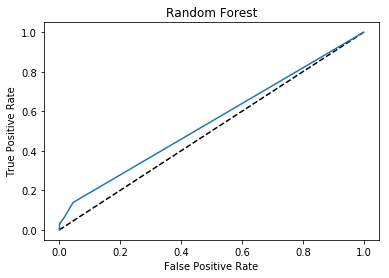

In [442]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rfc_fs_3, tpr_rfc_fs_3, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest')
plt.show();

In [443]:
auc_score_rfc_fs_3 = roc_auc_score(y_test, y_pred_prob_rfc_fs_3)
auc_score_rfc_fs_3

0.5472338841519439

In [149]:
y_pred_prob_upsampled_fs_10 = upsampled_fs_10.predict_proba(X_test)[:,1]
y_pred_prob_upsampled_fs_10

array([0.1751951 , 0.1817703 , 0.64357074, ..., 0.0029602 , 0.00228133,
       0.43991956])

In [150]:
fpr_upsampled_fs_10, tpr_upsampled_fs_10, thresholds_upsampled_fs_10 = roc_curve(y_test, y_pred_prob_upsampled_fs_10)

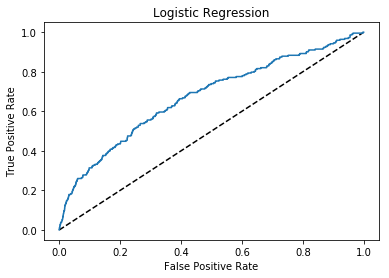

In [151]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_upsampled_fs_10, tpr_upsampled_fs_10, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.show();

In [152]:
auc_score_upsampled_fs_10 = roc_auc_score(y_test, y_pred_prob_upsampled_fs_10)
auc_score_upsampled_fs_10

0.6731829297308864

The 'upsampled_fs_10' LogisticRegression algorithm has a somewhat higher AUC score than the RandomForest classifier with 100 estimators.

Because of the imbalanced class count, the 10th LogisticRegression algorithm is evaluated below with a Precision-Recall Curve.

## Precision Recall Curve

The precision recall curve is defined below, as is the F1 score and AUC for the precision-recall curve.

In [153]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob_upsampled_fs_10)

In [154]:
lr_fs_f1, lr_fs_auc = f1_score(y_test, upsampled_fs_pred_10), auc(lr_recall, lr_precision)

The scores are then summarized.

In [155]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_fs_f1, lr_fs_auc))

Logistic: f1=0.019 auc=0.015


The precision-recall curve is then plotted for the best Logistic Regression algorithm. The precision-recall curve's AUC is very low, showing that the model does not have a good harmonic average of precision and recall for felony sales crimes but is not very skillful at predicting other cannabis crimes as a group.

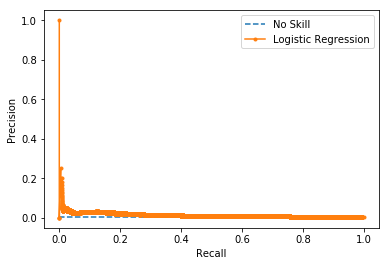

In [156]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Evaluation of the Classification Models for Felony Sales

The best LogisticRegression model ('upsampled_fs_1') has an accuracy of 0.708063820612332, showing that it makes correct predictions on roughly 70.1% of the data points in the DataFrame.

The model's precision is 0.01 for the felony sales class (the 1 class), 1.0 for the other cannabis crime types class (the 0 class), and 0.99 on weighted average, showing that 1% of predicted felony sales crimes are actual felony sales crimes, 100% of predicted other cannabis crimes are actual other cannabis crimes, and 99% of crimes on weighted average are predicted correctly. 

The model's recall is 0.56 for the felony sales class (the 1 class), 0.71 for the other cannabis crime types class (0), and 0.71 on weighted average, showing that 56% of actual felony sales crimes are predicted as felony sales crimes, 71% of actual other cannabis crimes are predicted as other cannabis crimes, and that 56% of crimes on weighted average are predicted correctly.

The model's F1 score, or harmonic mean of precision and recall, is 0.02 for the felony sales class, 0.83 for the other cannabis crimes class, and 0.82 on weighted average. This metric is more informative than precision or recall alone, and shows that only 2% of felony sales crimes and 83% of other cannabis crimes are being predicted correctly, for a weighted average of 77%.

The ROC curves plotted above show that the best LogisticRegression model ('upsampled_fs_10') has an ROC AUC score of 67.3%, showing that it is not a very skillful model in predicting felony sales crimes at a rate higher than random. The Precision Recall Curve has an AUC score of 1.5%. The extremely low Precision Recall AUC score shows that the model is not skilled at all at differentiating true positives from false positives and false negatives for the felony sales class. However, as is shown above, it is more skillful at predicting the other cannabis crime types as a group. Therefore, this model's coefficients cannot very well show the features in the NYPD's dataset that have the strongest statistical relationship with cannabis felony sales crimes between 2006 and 2018. The model's coefficients will be looked at below, but should be considered as highly speculative and only as an area for future research.

The RandomForest model with 100 estimators has an accuracy of 0.99396291504959. It has a 0.06 precision score for the felony sales class, a 1.0 precision score for the other crime types class, and a weighted average precision score of 0.99. The model has a recall score of 0.01 for the felony sales class, a 1.0 recall score for the other crime types class, and a weighted average recall score of 0.99. It has a 0.02 F1 score for the felony sales class, a 1.0 F1 score for the other crime types class, and a weighted average F1 score of 0.99. The ROC curve plotted above shows that it has an AUC score of 54.7%. This is an unskillful model at predicting felony sales crimes. 

## Coefficients for Felony Sales

As detailed above, the F1 score for the felony sales class is only 0.02 when using the best performing Logistic Regression algorithm 'upsampled_fs_10'. However, the coefficients can still be valuable in identifying salient features of felony sales crimes to a certain degree if the F1 score is higher than zero. The only scenario where the coefficients would definitely not be valuable is if the algorithm only or almost only predicts one class. To check on whether the algorithm predicts both classes, and not just one, the predicted values 'upsampled_fs_pred_10' are converted to a Pandas Series and then its value counts are called. As can be seen, the felony sales class is predicted 12,888 times and the other cannabis crime types as a group are predicted 31,173 times. Therefore, the coefficients for the felony sales class are valuable and are called and analyzed below.

In [41]:
upsampled_fs_pred_10_s = pd.Series(upsampled_fs_pred_10)
upsampled_fs_pred_10_s.value_counts()

0.0    31173
1.0    12888
dtype: int64

In order to look at the most salient predictors of cannabis felony sales crimes in New York City between 2006-2018, the feature set's coefficients for the best performing Logistic Regression algorithm ('upsampled_fs_10') are identified to find the most predictive features differentiating cannabis felony sales crimes from all other cannabis crimes.

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_fs_coeffs' (short for 'best classifier's coefficients').

In [26]:
best_cf_fs_coeffs = pd.Series(upsampled_fs_10.coef_[0], index=X_train.columns) 
best_cf_fs_coeffs

Latitude                                                                        -3.325161
Longitude                                                                       -5.890371
duration_days                                                                   -2.319232
start_year                                                                      -0.418103
start_month                                                                     -0.216434
start_day                                                                        0.120606
start_hour                                                                      -0.440505
start_minute                                                                    -0.144907
start_seconds                                                                    0.000000
rpt_cmplnt_dt_match                                                             -0.901791
day_tw                                                                          -0.565843
night_tw  

The features' coefficients are then sorted to show the features most predictive of cannabis felony sales crimes. The features with positive coefficients are more predictive of felony sales crimes, while the features with negative coefficients are more predictive of all other cannabis crimes. Because the '0' class, i.e. "all other cannabis crimes", is non-differentiated, there is no real value to the negative coefficients and they will be ignored.

In [27]:
sorted_best_cf_fs_coeffs = best_cf_fs_coeffs.sort_values()
sorted_best_cf_fs_coeffs

will_bridge_l2                                                                  -9.036317
will_bridge_l1                                                                  -6.261420
Longitude                                                                       -5.890371
empire_st_bldg_l1                                                               -5.277295
closest_subway_distance_l1                                                      -5.109661
PREM_TYP_DESC_AIRPORT TERMINAL                                                  -4.772659
downtown_bk_l2                                                                  -4.486906
labor_day                                                                       -4.061972
ADDR_PCT_CD_121.0                                                               -4.053333
ADDR_PCT_CD_78.0                                                                -4.048224
memorial_day                                                                    -4.030375
city_hall_

To look at which features have the strongest relationship to felony sales, the features that have at least a 0.709399 coefficient are called and speculated on below by assigning the object 'sorted_best_cf_fs_coeffs'. When exponentiated by assigning the object 'cannabis_fs_coeffs_lls', these features are shown to provide at least a 2% increase in the odds of a crime being a felony sales crime.

In [29]:
cannabis_fs_coeffs = sorted_best_cf_fs_coeffs[-153:].sort_values(ascending=False)
cannabis_fs_coeffs

prospect_pk_l2                                        11.405911
STATION_NAME_JUNIUS STREET                             8.889945
STATION_NAME_96 STREET                                 7.961853
HADEVELOPT_DOUGLASS ADDITION                           7.794246
HADEVELOPT_TAPSCOTT STREET REHAB                       6.237408
manh_bridge_l1                                         5.960881
HADEVELOPT_STERLING PLACE REHAB (STERLING-BUFFALO)     5.493379
HADEVELOPT_DOUGLASS                                    5.453678
STATION_NAME_3 AVENUE-149 STREET                       5.325795
HADEVELOPT_HOWARD AVENUE                               5.286719
HADEVELOPT_BUSHWICK II (GROUPS B & D)                  5.227074
PREM_TYP_DESC_TELECOMM. STORE                          5.160838
HADEVELOPT_QUEENSBRIDGE NORTH                          5.072055
HADEVELOPT_SACK WERN                                   5.017792
lincoln_ctr_l1                                         4.916903
STATION_NAME_DEKALB AVENUE              

In [30]:
cannabis_fs_coeffs_lls = np.array(np.exp(cannabis_fs_coeffs))
cannabis_fs_coeffs_lls

array([8.98512293e+04, 7.25861969e+03, 2.86938531e+03, 2.42659802e+03,
       5.11530857e+02, 3.87951709e+02, 2.43077128e+02, 2.33615789e+02,
       2.05571689e+02, 1.97693753e+02, 1.86246984e+02, 1.74310545e+02,
       1.59501769e+02, 1.51077429e+02, 1.36578914e+02, 1.35632454e+02,
       1.22488648e+02, 1.16482135e+02, 1.14309394e+02, 1.11569675e+02,
       1.06677475e+02, 1.05557383e+02, 1.01809181e+02, 7.51810860e+01,
       6.35842250e+01, 6.10270948e+01, 5.96674546e+01, 5.92190436e+01,
       5.63246429e+01, 5.59242648e+01, 5.55094619e+01, 5.38036823e+01,
       5.22384596e+01, 5.00514215e+01, 4.94460527e+01, 4.92725344e+01,
       4.54925995e+01, 4.33150876e+01, 4.18902574e+01, 3.90266049e+01,
       3.87704456e+01, 3.81798429e+01, 3.80422384e+01, 3.69768049e+01,
       3.61037570e+01, 3.48799087e+01, 3.29472112e+01, 3.03060953e+01,
       2.99225407e+01, 2.65615997e+01, 2.58707266e+01, 2.51955101e+01,
       2.41651680e+01, 2.37148973e+01, 2.22590503e+01, 2.21623766e+01,
      

## Feature Set Coefficients and Likelihoods

The features, their coefficients, and the increased likelihood towards felony sales crime are called in an Excel table below.

In [31]:
fs_coeffs_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_coeffs')
fs_coeffs_lls_table

,Feature,Coefficient,Increased Odds Towards Felony Sales Class
0,prospect_pk_l2,11.405911,89851.229300
1,STATION_NAME_JUNIUS STREET,8.889945,7258.619690
2,STATION_NAME_96 STREET,7.961853,2869.385310
3,HADEVELOPT_DOUGLASS ADDITION,7.794246,2426.598020
4,HADEVELOPT_TAPSCOTT STREET REHAB,6.237408,511.530857
5,manh_bridge_l1,5.960881,387.951709
6,HADEVELOPT_STERLING PLACE REHAB (STERLING-BUFF...,5.493379,243.077128
7,HADEVELOPT_DOUGLASS,5.453678,233.615789
8,STATION_NAME_3 AVENUE-149 STREET,5.325795,205.571689
9,HADEVELOPT_HOWARD AVENUE,5.286719,197.693753


The specific premises features with the highest coefficients show that felony sales arrests have the strongest relationship with telecommunication stores with an increased likelihood of 174% and clothing stores and boutiques with an increased likelihood of 116%. Chain stores, beauty and nail salons, dry cleaners and laundromats, and livery licensed taxis have an increased likelihood of 53.8%, 49.4%, 38.2%, 21% respectively. This really suggests that there are many people with legitimate businesses that are distributing cannabis on the side, as it is unlikely that people not associated with these businesses are coming in to the business and conducting felony level sales. Other premises where felony level cannabis sales are occurring are public schools, highways and parkways, open areas and lots, bars and night clubs, tunnels, fast food restaurants, unclassified stores, bus terminals, groceries and bodegas, residential houses, commercial buildings, others, streets, residential apartment houses, public parking lots and garages, and public buildings. The increased likelihood of a cannabis crime being a felony sales crime for these other features range from 3% to 20%.

There is only one NYC park associated with felony sales. If a cannabis crime occurs on Coney Island Beach and Boardwalk, there is an increased likelihood of 45.5% that it is a felony sales crime.

Felony sales arrests have several strong relationships with specific subway/transit stations. These include (in descending order of coefficients and likelihoods):

- Junius Street in the Brownsville neighborhood of eastern Brooklyn (7,260% increase), 

- 96th Street unusually on the Upper East Side of Manhattan (2,870% increase), 

- 3rd Avenue-149th Street in the South Bronx (206% increase), 

- Dekalb Avenue in the Fort Greene neighborhood of Brooklyn (136% increase), 

- Stillwell Avenue-Coney Island in the Coney Island neighborhood of southern Brooklyn (112% increase), 

- Pacific Street (unclear location) (59.2% increase), and 

- Myrtle Avenue in the Bushwick neighborhood of central Brooklyn (15.7% increase)

The following transit districts have strong to weak relationships with felony sales crimes:

- Transit District 32 in the Crown Heights neighborhood of Central Brooklyn (22.2% increased likelihood),

- Transit District 33 in the Bedford-Stuyvesant neighborhood of Central Brooklyn (8.9% increased likelihood),

- Transit District 3 in West Harlem (6.5% increase), and 

- Transit District 34 in Coney Island, Brooklyn (2.3% increased odds)

Intriguingly, the 65+ suspect age group has a 3.3% increased likelihood of felony sales crime. This is a rather modest increased likelihood in a small group of felony sales crimes, so its likely just due to a few individual sellers and not a deeper trend of older people selling cannabis.

The only suspect race group with an increased likelihood of felony sales crimes are White Hispanics, with a 2.1% increased likelihood.

For each full latitude/longitude unit closer a cannabis crime is to Prospect Park in L2 terms, there is a 89,900% increased odds that it is a felony sales charge and not another cannabis crime. This shows that felony sales charges have an extremely strong relationship with Prospect Park and nearby areas.

For each full latitude/longitude unit closer a cannabis crime is to the Manhattan Bridge in L1 terms, there is a 388% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the Lincoln Center in L1 terms, there is a 137% increased odds that it is a felony sales charge and not another cannabis crime. For each full latitude/longitude unit closer a cannabis crime is to the Lincoln Center in L2 terms, there is a 52.2% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the Port Authority Bus Terminal in L1 terms, there is a 102% increased odds that it is a felony sales charge and not another cannabis crime. For each full latitude/longitude unit closer a cannabis crime is to the Port Authority Bus Terminal in L2 terms, there is a 63.6% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the Brooklyn Bridge in L1 terms, there is a 50.1% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Washington Square Park in L2 terms, there is a 49.3% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Mets Stadium in L1 terms, there is a 21.3% increased odds that it is a felony sales charge and not another cannabis crime. For each full latitude/longitude unit closer a cannabis crime is to Mets Stadium in L2 terms, there is a 15.2% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the Apollo Theatre in L2 terms, there is a 12.3% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the Metropolitan Detention Center in L1 terms, there is a 10.5% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Penn Station in L2 terms, there is a 9.2% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the New York Stock Exchange in L2 terms, there is a 4.1% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Times Square in L1 terms, there is a 4% increased odds that it is a felony sales charge and not another cannabis crime. For each full latitude/longitude unit closer a cannabis crime is to Times Square in L2 terms, there is a 7.8% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Union Square in L2 terms, there is a 6.5% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Riker's Island in L1 terms, there is a 3.4% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the World Trade Center in L2 terms, there is a 2.4% increased odds that it is a felony sales charge and not another cannabis crime.

The borough of Queens has a relationship with felony sales crimes. If a cannabis crime is committed in Queens, there is a 25.2% increased likelihood that it is a felony sales crime, showing that even though Queens as as whole doesn't have a lot of cannabis arrests, there is a significant amount of felony sales arrests.

The patrol boroughs with the strongest relationship to felony sales arrests is the Bronx and Brooklyn North patrol boroughs, with an increased likelihood of 16.8% and 2.4%, respectively.

The holidays with a notable relationship to felony sales arrests are Thanksgiving and Martin Luther King Day, Jr., with an increased likelihood of 7.4% and 3.3% respectively.

Cannabis arrests made in the early morning have a 9.1% increased likelihood of being felony sales arrests, and those made in the morning rush hour have a 3.2% increaed likelihood. This is likely due to the police practice of early morning raids on locales suspected of containing felony possession amounts with intent to distribute.

Police precincts with the highest relationship to misdemeanor sales crime, in descending order, are the 45th, 10th, 123rd, 20th, 19th, 14th, 79th, 109th, 13th, 69th, 5th, 34th, 62nd, 71st, 72nd, 122nd, 106th, 25th, 67th, 90th, 83rd, 61st, 112th, and 47th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 45th - A portion of the northeastern section of the Bronx (10.1% increase),

- 10th - Chelsea, Clinton/Hell's Kitchen South and the Hudson Yards neighborhoods (6.6% increase)

- 123rd - A portion of the South Shore of Staten Island, including Tottenville, Huguenot, Rossville, Annadale, and Eltingville (5.2% increase)

- 20th - A northern portion of Brooklyn that includes Bedford Stuyvesant and features Herbert Von King Park (4.9% increase)

- 19th - The Upper East Side of Manhattan (4.8% increase)

- 14th - The southern portion of Midtown, Manhattan. The area contains commercial offices, hotels, Times Square, Grand Central Terminal, Penn Station, Madison Square Garden, Koreatown section, and the Manhattan Mall Plaza (4.6% increase)

- 79th - Northern portion of Brooklyn that includes Bedford Stuyvesant and features Herbert Von King Park (4.5% increase)

- 109th - Northeast portion of Queens, including Downtown Flushing, East Flushing, Queensboro Hill, College Point, Malba, Whitestone, Beechhurst, and Bay Terrace (4.5% increase)

- 13th - Southern portion of Midtown, Manhattan. The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park (4.1% increase)

- 69th - The Canarsie section of eastern Brooklyn (3.4% increase)

- 5th - Southeastern edge of Manhattan, home to Chinatown, Little Italy, and the Bowery (3% increase)

- 34th - Communities of Washington Heights and Inwood, north of West 179th Street (2.7% increase), a traditionally Hispanic neighborhood (2.8% increase)

- 62nd - Southwestern portion of Brooklyn, home to Bensonhurst, Mapleton, and Bath Beach (2.4% increase)

- 71st - Crown Heights, Wingate, Prospect Lefferts neighborhoods of Central Brooklyn (2.4% increase)

- 72nd - Northwestern portion of Brooklyn that includes Sunset Park and Windsor Terrace (2.3% increase)

- 122nd - A portion of the South Shore of Staten Island, which encompasses Eltingville, Great Kills, Bay Terrace, Oakwood Heights, Oakwood Beach, Lighthouse Hill, New Dorp, Grant City, Midland Beach, South Beach, Todt Hill, South Beach, Old Town, and Grasmere (2.3% increase)

- 106th - South Central Queens, and includes Ozone Park, South Ozone Park, Lindenwood, Howard Beach, and Old Howard Beach (2.2% increase)

- 25th - Northern portion of East Harlem, home to a large residential community as well as Marcus Garvey Park, Harlem Art Park, and the 125th Street Metro-North Station (2.2% increase)

- 67th - East Flatbush and Remsen Village neighborhoods of Central Brooklyn (2.2% increase)

- 90th - The northwestern portion of Brooklyn that mainly consists of the neighborhood of Williamsburg (2.1% increase)

- 83rd - Northern region in Brooklyn comprising Bushwick (2.1% increase)

- 61st - A southern portion of Brooklyn encompassing Kings Bay, Gravesend, Sheepshead Bay, and Manhattan Beach (2.1% increase)

- 112th - Centrally located portion of Queens, housing Forest Hills and Rego Park, reflecting the strong relationship between the Pomonok Houses project in this portion of Queens (2% increase)

- 47th - A northern portion of the Bronx, encompassing Woodlawn, Wakefield, Williamsbridge, Baychester, Edenwald, Olinville, Fishbay, and Woodlawn Cemetary (2% increase)

The jurisdictions with the strongest relationship to felony sales arrests, in descending order, are the following:

- N.Y. State Police (9.4% increase),

- Port Authority (5.1% increase),

- Other (3.5% increase),

- N.Y. Housing Police (2.5% increase),

- Police Dept NYC (2.4% increase),

- N.Y. Police Dept (2.4% increase)

There are many public housing developments (or projects) that have a strong relationship with felony sales crimes, again highlighting that public housing developments are home to many cannabis arrests. These include:

- Douglass Addition on the Upper West Side of Manhattan (2,430% increase),

- Tapscott Street Rehab in the New Lots neighborhood of Central Brooklyn (512% increase),

- Sterling Place Rehab (Sterling-Buffalo) in the Weeksville neighborhood of Central Brooklyn close to Crown Heights (243% increase),

- Douglass on the Upper West Side of Manhattan (234% increase),

- Howard Avenue in the Brownsville neighborhood of Eastern Brooklyn (198% increase),

- Bushwick II (Groups B & D) in the Bushwick neighborhood of central Brooklyn (186% increase),

- Queensbridge North between the Astoria and Hunters Point neighborhoods of Queens (160% increase), 

- Sack Wern in the Soundview neighborhood of the South Bronx (151% increase),

- Claremont Parkway-Franklin Avenue in the Claremont Village of the South Bronx (122% increase),

- Harlem River in the Harlem neighborhood of northern Manhattan (114% increase),

- Seward Park Extension in the Lower East Side neighborhood of southern Manhattan (107% increase),

- Lower East Side Rehab (Group 5) in the Lower East Side neighborhood of southern Manhattan (106% increase),

- Castle Hill in the Castle Hill neighborhood of the South Bronx (61% increase),

- Bayside-Ocean Bay Apts in the Arverne neighborhood of southern Brooklyn (59.7% increase),

- Soundview in the Soundview neighborhood of the South Bronx (56.3% increase),

- Albany II in the Crown Heights neighborhood of central Brooklyn (55.9% increase),

- Bushwick II (Groups A & C) in the Bushwick neighborhood of central Brooklyn (55.5% increase),

- Monroe in the Soundview neighborhood of the South Bronx (43.3% increase),

- Tilden in the Brownsville neighborhood of eastern Brooklyn (41.9% increase),

- Morris II in the Claremont neighborhood of central Bronx (39% increase),

- Van Dyke I in the Brownsville neighborhood of Eastern Brooklyn (38.8% increase), 

- Bronx River in the Van Nest neighborhood of the South Bronx (38% increase), 

- Fort Independence Street-Heath Avenue in the Van Cortlandt neighborhood of the Bronx (37% increase),

- Brownsville in the Brownsville neighborhood of Eastern Brooklyn (36.1% increase),

- Baruch in the Lower East Side neighborhood of southern Manhattan (34.9% increase), 

- Red Hook West in the Red Hook neighborhood of Western Brooklyn (32.9% increase),

- Brevoort in the Stuyvesant Heights neighborhood near Bedford-Stuyvesant in central Brooklyn (30.3% increase),

- Davidson in the Morrisania neighborhood of the South Bronx (29.9% increase),

- Roosevelt II in the Bedford-Stuyvesant neighborhood of Central Brooklyn (26.6% increase),

- Bay View in the East New York neighborhood of Brooklyn (25.9% increase), 

- Wald in the Alphabet City neighborhood of Lower Manhattan (24.2% increase), 

- Taft in East Harlem (23.7% increase),

- Glenwood in the East Flatbush neighborhood of central Brooklyn (22.3% increase),

- Pomonok Houses in the Pomonok neighborhood of Queens (18.9% increase),

- Moore Houses in the South Bronx (16.5% increase),

- Manhattanville in the Manhattanville neighborhood of West Harlem (15.6% increase),

- Richmond Terrace in northern Staten Island (15.3% increase),

- Jackson in the Concourse Village of the South Bronx (14.4% increase), 

- Grant in the Manhattanville neighborhood of Harlem (12.5% increase), 

- Saint Mary's Park in the Mott Haven neighborhood of the South Bronx (12.4% increase),

- Coney Island I (Site 1B) in the Coney Island neighborhood of southern Brooklyn (11.5% increase),

- Betances I in the South Bronx (11.2% increase),

- Ingersoll in downtown Brooklyn (9.4% increase),

- Gowanus in the Gowanus neighborhood of southern Brooklyn (9.2% increase),

- Bushwick in the Bushwick neighborhood of northern Brooklyn (9% increase), 

- Borinquen Plaza I in the Bushwick neighborhood of northern Brooklyn (9% increase), 

- Borinquen Plaza II in the Bushwick neighborhood of northern Brooklyn (8.8% increase),

- Butler in the Claremont neighborhood of central Bronx (6.4% increase),

- Johnson in East Harlem in northern Manhattan (6.3% increase),

- Williamsburg in the Williamsburg neighborhood of Brooklyn (5.9% increase),

- West Brighton I in northern Staten Island (5.7% increase),

- Armstrong I in Bedford-Stuyvesant, in a classically African-American neighborhood of Brooklyn (5.2% increase),

- Whitman in the Fort Greene neighborhood of Brooklyn (4.7% increase),

- Mitchel in the Mott Haven neighborhood of the South Bronx (3.5% increase),

- Sumner in the Bedford-Stuyvesant neighborhood of Central Brooklyn (3.5% increase),

- Lincoln in East Harlem in northern Manhattan (3.4% increase),

- Nostrand in the Sheepshead Bay neighborhood of southern Brooklyn (2.9% increase), and

- Throggs Neck in the Throggs Neck neighborhood of the South Bronx (2.6% increase)

## Relationship of 'Feature Families' to Crime: Felony Sales and Other Cannabis Crime Types

Because there are so many binarized features in the feature set, the interpretability of these features' coefficients and increased odds towards felony sales is better enabled by grouping the features into "feature families" (e.g. suspect race, borough, housing development). This grouping strategy involves taking the absolute value sum of all coefficients in the feature set, then summing the absolute values of the coefficients for each "feature family", and then dividing the absolute value coefficient sum of each "feature family" by the total absolute value coefficient sum to uncover the proportion of the total predictive value that each "feature family" has. This will help elucidate the "feature families" that have the strongest predictive power on whether a crime is a felony sales crime or another type of cannabis crime, and therefore which feature families should be explored further as having the strongest relationship to felony sales.

A summary table of the sum of all coefficients, the sum of coefficients for each feature family, and the proportion of the total sum of all coefficients that each feature family has is called below. Any family with more than five percent of the total coefficient sum will be examined further. That includes housing developments, premises types, transit stations, police precincts, and L1 and L2 distances from NYC landmarks. Because suspect race is a main concern of arrest biases when it comes to cannabis crime, it is also examined.

In [114]:
proportions_table_fs = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_family_props')
proportions_table_fs

,Feature Family,Sum of Coeffs,Proportion of Total Coeffs,Unnamed: 3
0,"Sum of all coeffs, absolute value",NaN,NaN,920.914946
1,Housing Developments,387.125485,0.420371,NaN
2,Premises Types,117.706077,0.127814,NaN
3,Transit Stations,79.367670,0.086183,NaN
4,Police Precincts,69.176242,0.075117,NaN
5,L1 Distances from NYC Landmarks,64.160815,0.069671,NaN
6,L2 Distances from NYC Landmarks,64.059082,0.069560,NaN
7,Holidays,30.576244,0.033202,NaN
8,Transit Districts,18.649198,0.020251,NaN
9,NYC Parks,17.349193,0.018839,NaN


In [32]:
sum_of_all_coeffs_fs = np.sum(abs(sorted_best_cf_fs_coeffs.values))
sum_of_all_coeffs_fs

920.91494626691

In [33]:
is_race_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_race_coeffs_fs.append(name.startswith('SUSP_RACE_'))
is_race_coeffs_fs = np.array(is_race_coeffs_fs)

In [34]:
race_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_race_coeffs_fs]

In [35]:
sum_of_race_coeffs_fs = np.sum(abs(race_coeffs_fs.values))
sum_of_race_coeffs_fs

5.145584774302586

In [37]:
race_proportion_of_total_fs = sum_of_race_coeffs_fs / sum_of_all_coeffs_fs
race_proportion_of_total_fs

0.0055874701514630806

In [38]:
is_police_precinct_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_police_precinct_coeffs_fs.append(name.startswith('ADDR_PCT_CD_'))
is_police_precinct_coeffs_fs = np.array(is_police_precinct_coeffs_fs)

In [39]:
police_precinct_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_police_precinct_coeffs_fs]

In [40]:
sum_of_police_precinct_coeffs_fs = np.sum(abs(police_precinct_coeffs_fs.values))
sum_of_police_precinct_coeffs_fs

69.17624199665849

In [41]:
police_precinct_proportion_of_total_fs = sum_of_police_precinct_coeffs_fs / sum_of_all_coeffs_fs
police_precinct_proportion_of_total_fs

0.0751168631555786

In [42]:
is_borough_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_borough_coeffs_fs.append(name.startswith('BORO_NM_'))
is_borough_coeffs_fs = np.array(is_borough_coeffs_fs)

In [43]:
borough_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_borough_coeffs_fs]

In [44]:
sum_of_borough_coeffs_fs = np.sum(abs(borough_coeffs_fs.values))
sum_of_borough_coeffs_fs

8.573722485790011

In [45]:
borough_proportion_of_total_fs = sum_of_borough_coeffs_fs / sum_of_all_coeffs_fs
borough_proportion_of_total_fs

0.009310004708409932

In [46]:
is_housing_developt_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_housing_developt_coeffs_fs.append(name.startswith('HADEVELOPT_'))
is_housing_developt_coeffs_fs = np.array(is_housing_developt_coeffs_fs)

In [47]:
housing_developt_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_housing_developt_coeffs_fs]

In [48]:
sum_of_housing_developt_coeffs_fs = np.sum(abs(housing_developt_coeffs_fs.values))
sum_of_housing_developt_coeffs_fs

387.1254847960254

In [49]:
housing_developt_proportion_of_total_fs = sum_of_housing_developt_coeffs_fs / sum_of_all_coeffs_fs
housing_developt_proportion_of_total_fs

0.42037050909566226

In [50]:
is_juris_desc_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_juris_desc_coeffs_fs.append(name.startswith('JURIS_DESC_'))
is_juris_desc_coeffs_fs = np.array(is_juris_desc_coeffs_fs)

In [52]:
juris_desc_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_juris_desc_coeffs_fs]

In [53]:
sum_of_juris_desc_coeffs_fs = np.sum(abs(juris_desc_coeffs_fs.values))
sum_of_juris_desc_coeffs_fs

16.65191447651532

In [54]:
juris_desc_proportion_of_total_fs = sum_of_juris_desc_coeffs_fs / sum_of_all_coeffs_fs
juris_desc_proportion_of_total_fs

0.018081924442660824

In [55]:
is_loc_of_occur_desc_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_loc_of_occur_desc_coeffs_fs.append(name.startswith('LOC_OF_OCCUR_DESC_'))
is_loc_of_occur_desc_coeffs_fs = np.array(is_loc_of_occur_desc_coeffs_fs)

In [56]:
loc_of_occur_desc_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_loc_of_occur_desc_coeffs_fs]

In [57]:
sum_of_loc_of_occur_desc_coeffs_fs = np.sum(abs(loc_of_occur_desc_coeffs_fs.values))
sum_of_loc_of_occur_desc_coeffs_fs

1.0742939775795437

In [58]:
loc_of_occur_desc_proportion_of_total_fs = sum_of_loc_of_occur_desc_coeffs_fs / sum_of_all_coeffs_fs
loc_of_occur_desc_proportion_of_total_fs

0.0011665507025750668

In [59]:
latitude_coeff_proportion_of_total_fs = abs(sorted_best_cf_fs_coeffs.loc['Latitude']) / sum_of_all_coeffs_fs
latitude_coeff_proportion_of_total_fs

0.003610714599839146

In [60]:
longitude_coeff_proportion_of_total_fs = abs(sorted_best_cf_fs_coeffs.loc['Longitude']) / sum_of_all_coeffs_fs
longitude_coeff_proportion_of_total_fs

0.006396216225794523

In [61]:
is_parks_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_parks_coeffs_fs.append(name.startswith('PARKS_NM_'))
is_parks_coeffs_fs = np.array(is_parks_coeffs_fs)

In [62]:
parks_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_parks_coeffs_fs]

In [63]:
sum_of_parks_coeffs_fs = np.sum(abs(parks_coeffs_fs.values))
sum_of_parks_coeffs_fs

17.349192676093523

In [64]:
parks_proportion_of_total_fs = sum_of_parks_coeffs_fs / sum_of_all_coeffs_fs
parks_proportion_of_total_fs

0.018839082530283078

In [65]:
is_patrol_boro_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_patrol_boro_coeffs_fs.append(name.startswith('PATROL_BORO_'))
is_patrol_boro_coeffs_fs = np.array(is_patrol_boro_coeffs_fs)

In [66]:
patrol_boro_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_patrol_boro_coeffs_fs]

In [67]:
sum_of_patrol_boro_coeffs_fs = np.sum(abs(patrol_boro_coeffs_fs.values))
sum_of_patrol_boro_coeffs_fs

9.371600698731246

In [68]:
patrol_boro_proportion_of_total_fs = sum_of_patrol_boro_coeffs_fs / sum_of_all_coeffs_fs
patrol_boro_proportion_of_total_fs

0.01017640199751418

In [69]:
is_prem_typ_desc_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_prem_typ_desc_coeffs_fs.append(name.startswith('PREM_TYP_DESC_'))
is_prem_typ_desc_coeffs_fs = np.array(is_prem_typ_desc_coeffs_fs)

In [70]:
prem_typ_desc_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_prem_typ_desc_coeffs_fs]

In [71]:
sum_of_prem_typ_desc_coeffs_fs = np.sum(abs(prem_typ_desc_coeffs_fs.values))
sum_of_prem_typ_desc_coeffs_fs

117.7060766738099

In [72]:
prem_typ_desc_proportion_of_total_fs = sum_of_prem_typ_desc_coeffs_fs / sum_of_all_coeffs_fs
prem_typ_desc_proportion_of_total_fs

0.12781427552126512

In [73]:
is_station_name_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_station_name_coeffs_fs.append(name.startswith('STATION_NAME_'))
is_station_name_coeffs_fs = np.array(is_station_name_coeffs_fs)

In [74]:
station_name_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_station_name_coeffs_fs]

In [75]:
sum_of_station_name_coeffs_fs = np.sum(abs(station_name_coeffs_fs.values))
sum_of_station_name_coeffs_fs

79.36767028732577

In [76]:
station_name_proportion_of_total_fs = sum_of_station_name_coeffs_fs / sum_of_all_coeffs_fs
station_name_proportion_of_total_fs

0.08618349675945267

In [77]:
is_susp_age_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_susp_age_coeffs_fs.append(name.startswith('SUSP_AGE_'))
is_susp_age_coeffs_fs = np.array(is_susp_age_coeffs_fs)

In [78]:
susp_age_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_susp_age_coeffs_fs]

In [79]:
sum_of_susp_age_coeffs_fs = np.sum(abs(susp_age_coeffs_fs.values))
sum_of_susp_age_coeffs_fs

3.473840237714522

In [80]:
susp_age_proportion_of_total_fs = sum_of_susp_age_coeffs_fs / sum_of_all_coeffs_fs
susp_age_proportion_of_total_fs

0.003772161861197217

In [81]:
is_susp_sex_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_susp_sex_coeffs_fs.append(name.startswith('SUSP_SEX_'))
is_susp_sex_coeffs_fs = np.array(is_susp_sex_coeffs_fs)

In [82]:
susp_sex_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_susp_sex_coeffs_fs]

In [83]:
sum_of_susp_sex_coeffs_fs = np.sum(abs(susp_sex_coeffs_fs.values))
sum_of_susp_sex_coeffs_fs

1.4913472402629546

In [84]:
susp_sex_proportion_of_total_fs = sum_of_susp_sex_coeffs_fs / sum_of_all_coeffs_fs
susp_sex_proportion_of_total_fs

0.00161941908566952

In [85]:
is_transit_district_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_transit_district_coeffs_fs.append(name.startswith('TRANSIT_DISTRICT_'))
is_transit_district_coeffs_fs = np.array(is_transit_district_coeffs_fs)

In [86]:
transit_district_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_transit_district_coeffs_fs]

In [87]:
sum_of_transit_district_coeffs_fs = np.sum(abs(transit_district_coeffs_fs.values))
sum_of_transit_district_coeffs_fs

18.64919788893096

In [88]:
transit_district_proportion_of_total_fs = sum_of_transit_district_coeffs_fs / sum_of_all_coeffs_fs
transit_district_proportion_of_total_fs

0.020250727783850994

In [89]:
holidays_fs = ['christmas', 'christmas_eve', 'diwali', 'easter', 'eid_al_adha', 'eid_al_fitr', 'four_twenty', 
           'halloween', 'hanukkah', 'july_4th', 'labor_day', 'memorial_day', 'mlk', 'new_years_day', 
           'new_years_eve', 'pr_parade', 'pres', 'rosh_hashanah', 'st_patricks', 'thanksgiving', 
           'valentines', 'yomkippur']

In [90]:
is_holidays_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_holidays_coeffs_fs.append(name in holidays_fs)
is_holidays_coeffs_fs = np.array(is_holidays_coeffs_fs)

In [91]:
holidays_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_holidays_coeffs_fs]

In [92]:
sum_of_holidays_coeffs_fs = np.sum(abs(holidays_coeffs_fs.values))
sum_of_holidays_coeffs_fs

30.576244054770168

In [93]:
holidays_proportion_of_total_fs = sum_of_holidays_coeffs_fs / sum_of_all_coeffs_fs
holidays_proportion_of_total_fs

0.03320202824236519

In [94]:
time_windows_fs = ['day_tw', 'dinner', 'early_morn', 'eve_rush_hr', 'evening', 'late_night', 'lunch_hr', 
                'morn_rush_hr', 'night_tw', 'work_day']

In [95]:
is_time_windows_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_time_windows_coeffs_fs.append(name in time_windows_fs)
is_time_windows_coeffs_fs = np.array(is_time_windows_coeffs_fs)

In [96]:
time_windows_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_time_windows_coeffs_fs]

In [97]:
sum_of_time_windows_coeffs_fs = np.sum(abs(time_windows_coeffs_fs.values))
sum_of_time_windows_coeffs_fs

5.879956359700029

In [98]:
time_windows_proportion_of_total_fs = sum_of_time_windows_coeffs_fs / sum_of_all_coeffs_fs
time_windows_proportion_of_total_fs

0.006384907079134139

In [99]:
l1_landmark_dists_fs = ['apollo_th_l1', 'bk_bridge_l1', 'central_pk_l1', 'city_hall_l1', 'downtown_bk_l1', 
                    'empire_st_bldg_l1', 'lincoln_ctr_l1', 'manh_bridge_l1', 'mdc_l1', 'mets_stad_l1', 
                    'nypd_hq_l1', 'nysc_l1', 'nyse_l1', 'penn_station_l1', 'port_authority_l1', 
                    'prospect_pk_l1', 'queens_l1', 'rikers_l1', 'rock_center_l1', 'si_ferry_l1', 
                    'times_sq_l1', 'union_sq_l1', 'wash_sq_park_l1', 'will_bridge_l1', 'wtc_l1', 'yankee_stad_l1']

In [100]:
is_l1_landmark_dists_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_l1_landmark_dists_coeffs_fs.append(name in l1_landmark_dists_fs)
is_l1_landmark_dists_coeffs_fs = np.array(is_l1_landmark_dists_coeffs_fs)

In [101]:
l1_landmark_dists_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_l1_landmark_dists_coeffs_fs]

In [102]:
sum_of_l1_landmark_dists_coeffs_fs = np.sum(abs(l1_landmark_dists_coeffs_fs.values))
sum_of_l1_landmark_dists_coeffs_fs

64.16081524646042

In [103]:
l1_landmark_dists_proportion_of_total_fs = sum_of_l1_landmark_dists_coeffs_fs / sum_of_all_coeffs_fs
l1_landmark_dists_proportion_of_total_fs

0.0696707285581014

In [104]:
l2_landmark_dists_fs = ['apollo_th_l2', 'bk_bridge_l2', 'central_pk_l2', 'city_hall_l2', 'downtown_bk_l2', 
                    'empire_st_bldg_l2', 'lincoln_ctr_l2', 'manh_bridge_l2', 'mdc_l2', 'mets_stad_l2', 
                    'nypd_hq_l2', 'nysc_l2', 'nyse_l2', 'penn_station_l2', 'port_authority_l2', 
                    'prospect_pk_l2', 'queens_l2', 'rikers_l2', 'rock_center_l2', 'si_ferry_l2', 
                    'times_sq_l2', 'union_sq_l2', 'wash_sq_park_l2', 'will_bridge_l2', 'wtc_l2', 'yankee_stad_l2']

In [105]:
is_l2_landmark_dists_coeffs_fs = []
for name in sorted_best_cf_fs_coeffs.index.values:
    is_l2_landmark_dists_coeffs_fs.append(name in l2_landmark_dists_fs)
is_l2_landmark_dists_coeffs_fs = np.array(is_l2_landmark_dists_coeffs_fs)

In [106]:
l2_landmark_dists_coeffs_fs = sorted_best_cf_fs_coeffs.loc[is_l2_landmark_dists_coeffs_fs]

In [107]:
sum_of_l2_landmark_dists_coeffs_fs = np.sum(abs(l2_landmark_dists_coeffs_fs.values))
sum_of_l2_landmark_dists_coeffs_fs

64.0590824500512

In [108]:
l2_landmark_dists_proportion_of_total_fs = sum_of_l2_landmark_dists_coeffs_fs / sum_of_all_coeffs_fs
l2_landmark_dists_proportion_of_total_fs

0.06956025929400529

In [109]:
sw_dist_l1_coeff_proportion_of_total_fs = abs(sorted_best_cf_fs_coeffs.loc['closest_subway_distance_l1']) / sum_of_all_coeffs_fs
sw_dist_l1_coeff_proportion_of_total_fs

0.005548460865808655

In [110]:
sw_dist_l2_coeff_proportion_of_total_fs = abs(sorted_best_cf_fs_coeffs.loc['closest_subway_distance_l2']) / sum_of_all_coeffs_fs
sw_dist_l2_coeff_proportion_of_total_fs

0.0023844853677129642

In [111]:
duration_coeff_proportion_of_total_fs = abs(sorted_best_cf_fs_coeffs.loc['duration_days']) / sum_of_all_coeffs_fs
duration_coeff_proportion_of_total_fs

0.002518399791389385

In [112]:
rpt_cmplnt_dt_match_coeff_proportion_of_total_fs = abs(sorted_best_cf_fs_coeffs.loc['rpt_cmplnt_dt_match']) / sum_of_all_coeffs_fs
rpt_cmplnt_dt_match_coeff_proportion_of_total_fs

0.000979234024946667

## Relationship of Housing Developments to Felony Sales

Out of all the feature families, the occurrence of a crime in a housing development most predicts which type of cannabis crime it is, felony sales or not felony sales. The absolute sum of its coefficients is 110.6, and its percentage of the entire absolute sum of coefficients is 36.1%. This definitely warrants looking closer at the strength of the relationship that housing developments have with felony sales cannabis crime.

Shown below are the specific housing developments where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony sales cannabis crime. Therefore, these specific housing developments show a moderate to strong relationship with felony sales cannabis crime.

In [117]:
top_hds_fs = housing_developt_coeffs_fs[-59:].sort_values(ascending=False)
top_hds_fs

HADEVELOPT_DOUGLASS ADDITION                          7.794246
HADEVELOPT_TAPSCOTT STREET REHAB                      6.237408
HADEVELOPT_STERLING PLACE REHAB (STERLING-BUFFALO)    5.493379
HADEVELOPT_DOUGLASS                                   5.453678
HADEVELOPT_HOWARD AVENUE                              5.286719
HADEVELOPT_BUSHWICK II (GROUPS B & D)                 5.227074
HADEVELOPT_QUEENSBRIDGE NORTH                         5.072055
HADEVELOPT_SACK WERN                                  5.017792
HADEVELOPT_CLAREMONT PARKWAY-FRANKLIN AVENUE          4.808018
HADEVELOPT_HARLEM RIVER                               4.738909
HADEVELOPT_SEWARD PARK EXTENSION                      4.669810
HADEVELOPT_LOWER EAST SIDE REHAB (GROUP 5)            4.659255
HADEVELOPT_CASTLE HILL                                4.111318
HADEVELOPT_BAYSIDE-OCEAN BAY APTS                     4.088787
HADEVELOPT_SOUNDVIEW                                  4.031132
HADEVELOPT_ALBANY II                                  4

In [118]:
top_hds_fs_lls = np.array(np.exp(top_hds_fs))
top_hds_fs_lls

array([2426.59801737,  511.53085674,  243.07712833,  233.61578906,
        197.69375341,  186.24698369,  159.50176876,  151.0774288 ,
        122.48864779,  114.30939414,  106.67747489,  105.557383  ,
         61.02709479,   59.66745457,   56.32464292,   55.92426476,
         55.50946185,   43.31508759,   41.89025737,   39.02660487,
         38.77044562,   38.04223836,   36.97680489,   36.10375702,
         34.87990874,   32.9472112 ,   30.30609531,   29.92254075,
         26.56159972,   25.87072662,   24.16516798,   23.71489731,
         22.25905028,   18.91145942,   16.5035919 ,   15.55458298,
         15.33614798,   14.4021487 ,   12.50473364,   12.41125241,
         11.45509871,   11.20879941,    9.40371987,    9.24485829,
          9.00884957,    9.00096196,    8.75719918,    6.3907945 ,
          6.27915511,    5.92154021,    5.72164714,    5.24219195,
          5.01453431,    4.7297392 ,    3.54407046,    3.4865846 ,
          3.4195287 ,    2.86262381,    2.62781992])

There are many public housing developments (or projects) that have a strong relationship with felony sales crimes, again highlighting that public housing developments are home to many cannabis arrests. These include:

- Douglass Addition on the Upper West Side of Manhattan (2,430% increase),

- Tapscott Street Rehab in the New Lots neighborhood of Central Brooklyn (512% increase),

- Sterling Place Rehab (Sterling-Buffalo) in the Weeksville neighborhood of Central Brooklyn close to Crown Heights (243% increase),

- Douglass on the Upper West Side of Manhattan (234% increase),

- Howard Avenue in the Brownsville neighborhood of Eastern Brooklyn (198% increase),

- Bushwick II (Groups B & D) in the Bushwick neighborhood of central Brooklyn (186% increase),

- Queensbridge North between the Astoria and Hunters Point neighborhoods of Queens (160% increase), 

- Sack Wern in the Soundview neighborhood of the South Bronx (151% increase),

- Claremont Parkway-Franklin Avenue in the Claremont Village of the South Bronx (122% increase),

- Harlem River in the Harlem neighborhood of northern Manhattan (114% increase),

- Seward Park Extension in the Lower East Side neighborhood of southern Manhattan (107% increase),

- Lower East Side Rehab (Group 5) in the Lower East Side neighborhood of southern Manhattan (106% increase),

- Castle Hill in the Castle Hill neighborhood of the South Bronx (61% increase),

- Bayside-Ocean Bay Apts in the Arverne neighborhood of southern Brooklyn (59.7% increase),

- Soundview in the Soundview neighborhood of the South Bronx (56.3% increase),

- Albany II in the Crown Heights neighborhood of central Brooklyn (55.9% increase),

- Bushwick II (Groups A & C) in the Bushwick neighborhood of central Brooklyn (55.5% increase),

- Monroe in the Soundview neighborhood of the South Bronx (43.3% increase),

- Tilden in the Brownsville neighborhood of eastern Brooklyn (41.9% increase),

- Morris II in the Claremont neighborhood of central Bronx (39% increase),

- Van Dyke I in the Brownsville neighborhood of Eastern Brooklyn (38.8% increase), 

- Bronx River in the Van Nest neighborhood of the South Bronx (38% increase), 

- Fort Independence Street-Heath Avenue in the Van Cortlandt neighborhood of the Bronx (37% increase),

- Brownsville in the Brownsville neighborhood of Eastern Brooklyn (36.1% increase),

- Baruch in the Lower East Side neighborhood of southern Manhattan (34.9% increase), 

- Red Hook West in the Red Hook neighborhood of Western Brooklyn (32.9% increase),

- Brevoort in the Stuyvesant Heights neighborhood near Bedford-Stuyvesant in central Brooklyn (30.3% increase),

- Davidson in the Morrisania neighborhood of the South Bronx (29.9% increase),

- Roosevelt II in the Bedford-Stuyvesant neighborhood of Central Brooklyn (26.6% increase),

- Bay View in the East New York neighborhood of Brooklyn (25.9% increase), 

- Wald in the Alphabet City neighborhood of Lower Manhattan (24.2% increase), 

- Taft in East Harlem (23.7% increase),

- Glenwood in the East Flatbush neighborhood of central Brooklyn (22.3% increase),

- Pomonok Houses in the Pomonok neighborhood of Queens (18.9% increase),

- Moore Houses in the South Bronx (16.5% increase),

- Manhattanville in the Manhattanville neighborhood of West Harlem (15.6% increase),

- Richmond Terrace in northern Staten Island (15.3% increase),

- Jackson in the Concourse Village of the South Bronx (14.4% increase), 

- Grant in the Manhattanville neighborhood of Harlem (12.5% increase), 

- Saint Mary's Park in the Mott Haven neighborhood of the South Bronx (12.4% increase),

- Coney Island I (Site 1B) in the Coney Island neighborhood of southern Brooklyn (11.5% increase),

- Betances I in the South Bronx (11.2% increase),

- Ingersoll in downtown Brooklyn (9.4% increase),

- Gowanus in the Gowanus neighborhood of southern Brooklyn (9.2% increase),

- Bushwick in the Bushwick neighborhood of northern Brooklyn (9% increase), 

- Borinquen Plaza I in the Bushwick neighborhood of northern Brooklyn (9% increase), 

- Borinquen Plaza II in the Bushwick neighborhood of northern Brooklyn (8.8% increase),

- Butler in the Claremont neighborhood of central Bronx (6.4% increase),

- Johnson in East Harlem in northern Manhattan (6.3% increase),

- Williamsburg in the Williamsburg neighborhood of Brooklyn (5.9% increase),

- West Brighton I in northern Staten Island (5.7% increase),

- Armstrong I in Bedford-Stuyvesant, in a classically African-American neighborhood of Brooklyn (5.2% increase),

- Whitman in the Fort Greene neighborhood of Brooklyn (4.7% increase),

- Mitchel in the Mott Haven neighborhood of the South Bronx (3.5% increase),

- Sumner in the Bedford-Stuyvesant neighborhood of Central Brooklyn (3.5% increase),

- Lincoln in East Harlem in northern Manhattan (3.4% increase),

- Nostrand in the Sheepshead Bay neighborhood of southern Brooklyn (2.9% increase), and

- Throggs Neck in the Throggs Neck neighborhood of the South Bronx (2.6% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly -0.004, which shows that housing developments on average are not a predictor of whether a cannabis crime is classified as a felony sales or another cannabis crime, and that all types of cannabis crime occur in housing developments. Housing developments are associated with roughly a 1% odds increase in a cannabis crime being classified as a felony sales crime.

In [119]:
mean_hd_coeffs_fs = np.mean(housing_developt_coeffs_fs)
mean_hd_coeffs_fs

-0.00416393014566832

In [120]:
mean_hd_coeffs_lls_fs = np.exp(mean_hd_coeffs_fs)
mean_hd_coeffs_lls_fs

0.9958447269913877

In [121]:
top_hds_lls_table_fs = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_hds_coeffs')
top_hds_lls_table_fs

,Housing Development,Coefficients,Increase in odds
0,HADEVELOPT_DOUGLASS ADDITION,7.794246,2426.598017
1,HADEVELOPT_TAPSCOTT STREET REHAB,6.237408,511.530857
2,HADEVELOPT_STERLING PLACE REHAB (STERLING-BUFF...,5.493379,243.077128
3,HADEVELOPT_DOUGLASS,5.453678,233.615789
4,HADEVELOPT_HOWARD AVENUE,5.286719,197.693753
5,HADEVELOPT_BUSHWICK II (GROUPS B & D),5.227074,186.246984
6,HADEVELOPT_QUEENSBRIDGE NORTH,5.072055,159.501769
7,HADEVELOPT_SACK WERN,5.017792,151.077429
8,HADEVELOPT_CLAREMONT PARKWAY-FRANKLIN AVENUE,4.808018,122.488648
9,HADEVELOPT_HARLEM RIVER,4.738909,114.309394


## Relationship of Premises Types to Felony Sales

The premises type of a crime also helps predict which type of cannabis crime it is, felony sales or another type. The absolute sum of the premises type coefficients is 117.7, and its percentage of the entire absolute sum of coefficients is 12.7%. This warrants looking closer at the strength of the relationship that premises type has with felony sales.

Shown below are the specific premises type where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony sales cannabis crime. Therefore, these specific premises types show a moderate to strong relationship with felony sales.

In [123]:
top_premises_fs = prem_typ_desc_coeffs_fs[-23:].sort_values(ascending=False)
top_premises_fs

PREM_TYP_DESC_TELECOMM. STORE                5.160838
PREM_TYP_DESC_CLOTHING/BOUTIQUE              4.757738
PREM_TYP_DESC_CHAIN STORE                    3.985342
PREM_TYP_DESC_BEAUTY & NAIL SALON            3.900882
PREM_TYP_DESC_DRY CLEANER/LAUNDRY            3.642308
PREM_TYP_DESC_TAXI (LIVERY LICENSED)         3.045040
PREM_TYP_DESC_PUBLIC SCHOOL                  3.032268
PREM_TYP_DESC_HIGHWAY/PARKWAY                2.492630
PREM_TYP_DESC_OPEN AREAS (OPEN LOTS)         2.445967
PREM_TYP_DESC_BAR/NIGHT CLUB                 2.311717
PREM_TYP_DESC_TUNNEL                         2.303475
PREM_TYP_DESC_FAST FOOD                      2.247541
PREM_TYP_DESC_STORE UNCLASSIFIED             2.242401
PREM_TYP_DESC_BUS TERMINAL                   2.176872
PREM_TYP_DESC_GROCERY/BODEGA                 2.068693
PREM_TYP_DESC_RESIDENCE-HOUSE                1.942266
PREM_TYP_DESC_COMMERCIAL BUILDING            1.712294
PREM_TYP_DESC_OTHER                          1.612216
PREM_TYP_DESC_STREET        

In [124]:
top_premises_fs_lls = np.array(np.exp(top_premises_fs))
top_premises_fs_lls

array([174.31054485, 116.48213462,  53.80368233,  49.44605273,
        38.1798429 ,  21.01087132,  20.74423641,  12.09303903,
        11.5417038 ,  10.09173673,  10.00890424,   9.46443217,
         9.41590887,   8.81868115,   7.91447052,   6.97453602,
         5.54165713,   5.01390782,   4.24590921,   4.1090977 ,
         3.8692041 ,   3.61205178,   2.9506601 ])

The specific premises features with the highest coefficients show that felony sales arrests have the strongest relationship with telecommunication stores with an increased likelihood of 174% and clothing stores and boutiques with an increased likelihood of 116%. Chain stores, beauty and nail salons, dry cleaners and laundromats, and livery licensed taxis have an increased likelihood of 53.8%, 49.4%, 38.2%, 21% respectively. This really suggests that there are many people with legitimate businesses that are distributing cannabis on the side, as it is unlikely that people not associated with these businesses are coming in to the business and conducting felony level sales. Other premises where felony level cannabis sales are occurring are public schools, highways and parkways, open areas and lots, bars and night clubs, tunnels, fast food restaurants, unclassified stores, bus terminals, groceries and bodegas, residential houses, commercial buildings, others, streets, residential apartment houses, public parking lots and garages, and public buildings. The increased likelihood of a cannabis crime being a felony sales crime for these other features range from 3% to 20%.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all premise types is roughly -0.02, which shows that premise types on average are not a predictor of whether a cannabis crime is classified as a felony sales or another cannabis crime, and that all types of cannabis crime occur on premises. Premise types are associated with roughly a 1% odds increase in a cannabis crime being classified as a felony sales crime.

In [125]:
mean_premises_coeffs_fs = np.mean(prem_typ_desc_coeffs_fs)
mean_premises_coeffs_fs

-0.015569477935929209

In [126]:
mean_premises_coeffs_lls_fs = np.exp(mean_premises_coeffs_fs)
mean_premises_coeffs_lls_fs

0.9845510997971427

In [127]:
top_premises_lls_table_fs = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_premises_coeffs')
top_premises_lls_table_fs

,Premises Types,Coefficients,Increase in odds
0,PREM_TYP_DESC_TELECOMM. STORE,5.160838,174.310545
1,PREM_TYP_DESC_CLOTHING/BOUTIQUE,4.757738,116.482135
2,PREM_TYP_DESC_CHAIN STORE,3.985342,53.803682
3,PREM_TYP_DESC_BEAUTY & NAIL SALON,3.900882,49.446053
4,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,3.642308,38.179843
5,PREM_TYP_DESC_TAXI (LIVERY LICENSED),3.045040,21.010871
6,PREM_TYP_DESC_PUBLIC SCHOOL,3.032268,20.744236
7,PREM_TYP_DESC_HIGHWAY/PARKWAY,2.492630,12.093039
8,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),2.445967,11.541704
9,PREM_TYP_DESC_BAR/NIGHT CLUB,2.311717,10.091737


## Relationship of Transit Stations to Felony Sales

The transit station with which a crime occurs in also has a relationship to which type of cannabis crime it is, felony sales or another cannabis crime. The absolute sum of transit stations' coefficients is 51.7, and its percentage of the entire absolute sum of coefficients is 15.5%. This warrants looking closer at the strength of the relationship that transit stations have with felony sales. 

Shown below are the specific transit stations where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony sales crime. Therefore, these specific transit stations show a moderate to strong relationship with felony sales.

In [129]:
top_stations_fs = station_name_coeffs_fs[-7:].sort_values(ascending=False)
top_stations_fs

STATION_NAME_JUNIUS STREET                    8.889945
STATION_NAME_96 STREET                        7.961853
STATION_NAME_3 AVENUE-149 STREET              5.325795
STATION_NAME_DEKALB AVENUE                    4.909949
STATION_NAME_STILLWELL AVENUE-CONEY ISLAND    4.714649
STATION_NAME_PACIFIC STREET                   4.081243
STATION_NAME_MYRTLE AVENUE                    2.753905
dtype: float64

In [130]:
top_stations_fs_lls = np.array(np.exp(top_stations_fs))
top_stations_fs_lls

array([7258.61968689, 2869.38531486,  205.571689  ,  135.63245378,
        111.5696751 ,   59.21904361,   15.70383023])

Felony sales arrests have several strong relationships with specific subway/transit stations. These include (in descending order of coefficients and likelihoods):

- Junius Street in the Brownsville neighborhood of eastern Brooklyn (7,260% increase), 

- 96th Street unusually on the Upper East Side of Manhattan (2,870% increase), 

- 3rd Avenue-149th Street in the South Bronx (206% increase), 

- Dekalb Avenue in the Fort Greene neighborhood of Brooklyn (136% increase), 

- Stillwell Avenue-Coney Island in the Coney Island neighborhood of southern Brooklyn (112% increase), 

- Pacific Street (unclear location) (59.2% increase), and 

- Myrtle Avenue in the Bushwick neighborhood of central Brooklyn (15.7% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all subway transit stations is roughly -0.004, which shows that subway transit stations on average are not a predictor of whether a cannabis crime is classified as a felony sales or another cannabis crime, and that all types of cannabis crime occur in subway transit stations. Subway transit stations are associated with roughly a 1% odds increase in a cannabis crime being classified as a felony sales crime.

In [131]:
mean_stations_coeffs_fs = np.mean(station_name_coeffs_fs)
mean_stations_coeffs_fs

-0.003476679539091764

In [132]:
mean_stations_coeffs_lls_fs = np.exp(mean_stations_coeffs_fs)
mean_stations_coeffs_lls_fs

0.9965293571133552

In [133]:
top_stations_lls_table_fs = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_stations_coeffs')
top_stations_lls_table_fs

,Transit Stations,Coefficients,Increase in odds
0,STATION_NAME_JUNIUS STREET,8.889945,7258.619687
1,STATION_NAME_96 STREET,7.961853,2869.385315
2,STATION_NAME_3 AVENUE-149 STREET,5.325795,205.571689
3,STATION_NAME_DEKALB AVENUE,4.909949,135.632454
4,STATION_NAME_STILLWELL AVENUE-CONEY ISLAND,4.714649,111.569675
5,STATION_NAME_PACIFIC STREET,4.081243,59.219044
6,STATION_NAME_MYRTLE AVENUE,2.753905,15.703830
7,"mean, actual values, directional",-0.003477,0.996529


## Relationship of Police Precincts to Felony Sales

The police precinct that a crime occurs in also helps predict which type of crime it is, felony sales or another type of cannabis crime. The absolute sum of the police precincts' coefficients is 69.2, and its percentage of the entire absolute sum of coefficients is 7.5%. This warrants looking closer at the strength of the relationship that police precincts have with felony sales.

Shown below are the specific police precincts where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony sales crime. Therefore, these specific police precincts show a moderate to strong relationship with felony sales.

In [135]:
top_precincts_fs = police_precinct_coeffs_fs[-24:].sort_values(ascending=False)
top_precincts_fs

ADDR_PCT_CD_45.0     2.310949
ADDR_PCT_CD_10.0     1.890876
ADDR_PCT_CD_123.0    1.650824
ADDR_PCT_CD_20.0     1.598180
ADDR_PCT_CD_19.0     1.562479
ADDR_PCT_CD_14.0     1.529337
ADDR_PCT_CD_79.0     1.505166
ADDR_PCT_CD_109.0    1.493334
ADDR_PCT_CD_13.0     1.408869
ADDR_PCT_CD_69.0     1.217569
ADDR_PCT_CD_5.0      1.100819
ADDR_PCT_CD_34.0     1.023264
ADDR_PCT_CD_62.0     0.863183
ADDR_PCT_CD_71.0     0.855574
ADDR_PCT_CD_72.0     0.848566
ADDR_PCT_CD_122.0    0.844122
ADDR_PCT_CD_106.0    0.803001
ADDR_PCT_CD_25.0     0.796117
ADDR_PCT_CD_67.0     0.794258
ADDR_PCT_CD_90.0     0.752356
ADDR_PCT_CD_83.0     0.742407
ADDR_PCT_CD_61.0     0.716773
ADDR_PCT_CD_112.0    0.712086
ADDR_PCT_CD_47.0     0.709399
dtype: float64

In [136]:
top_precincts_fs_lls = np.array(np.exp(top_precincts_fs))
top_precincts_fs_lls

array([10.08399109,  6.62516774,  5.21127087,  4.9440238 ,  4.77063417,
        4.61511564,  4.50490133,  4.45191502,  4.09132656,  3.37896263,
        3.00662866,  2.78226169,  2.37069415,  2.35272529,  2.33629381,
        2.32593573,  2.23222911,  2.21691681,  2.21279806,  2.12199332,
        2.10098661,  2.04781419,  2.03823761,  2.03276923])

Police precincts with the highest relationship to misdemeanor sales crime, in descending order, are the 45th, 10th, 123rd, 20th, 19th, 14th, 79th, 109th, 13th, 69th, 5th, 34th, 62nd, 71st, 72nd, 122nd, 106th, 25th, 67th, 90th, 83rd, 61st, 112th, and 47th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 45th - A portion of the northeastern section of the Bronx (10.1% increase),

- 10th - Chelsea, Clinton/Hell's Kitchen South and the Hudson Yards neighborhoods (6.6% increase)

- 123rd - A portion of the South Shore of Staten Island, including Tottenville, Huguenot, Rossville, Annadale, and Eltingville (5.2% increase)

- 20th - A northern portion of Brooklyn that includes Bedford Stuyvesant and features Herbert Von King Park (4.9% increase)

- 19th - The Upper East Side of Manhattan (4.8% increase)

- 14th - The southern portion of Midtown, Manhattan. The area contains commercial offices, hotels, Times Square, Grand Central Terminal, Penn Station, Madison Square Garden, Koreatown section, and the Manhattan Mall Plaza (4.6% increase)

- 79th - Northern portion of Brooklyn that includes Bedford Stuyvesant and features Herbert Von King Park (4.5% increase)

- 109th - Northeast portion of Queens, including Downtown Flushing, East Flushing, Queensboro Hill, College Point, Malba, Whitestone, Beechhurst, and Bay Terrace (4.5% increase)

- 13th - Southern portion of Midtown, Manhattan. The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park (4.1% increase)

- 69th - The Canarsie section of eastern Brooklyn (3.4% increase)

- 5th - Southeastern edge of Manhattan, home to Chinatown, Little Italy, and the Bowery (3% increase)

- 34th - Communities of Washington Heights and Inwood, north of West 179th Street (2.7% increase), a traditionally Hispanic neighborhood (2.8% increase)

- 62nd - Southwestern portion of Brooklyn, home to Bensonhurst, Mapleton, and Bath Beach (2.4% increase)

- 71st - Crown Heights, Wingate, Prospect Lefferts neighborhoods of Central Brooklyn (2.4% increase)

- 72nd - Northwestern portion of Brooklyn that includes Sunset Park and Windsor Terrace (2.3% increase)

- 122nd - A portion of the South Shore of Staten Island, which encompasses Eltingville, Great Kills, Bay Terrace, Oakwood Heights, Oakwood Beach, Lighthouse Hill, New Dorp, Grant City, Midland Beach, South Beach, Todt Hill, South Beach, Old Town, and Grasmere (2.3% increase)

- 106th - South Central Queens, and includes Ozone Park, South Ozone Park, Lindenwood, Howard Beach, and Old Howard Beach (2.2% increase)

- 25th - Northern portion of East Harlem, home to a large residential community as well as Marcus Garvey Park, Harlem Art Park, and the 125th Street Metro-North Station (2.2% increase)

- 67th - East Flatbush and Remsen Village neighborhoods of Central Brooklyn (2.2% increase)

- 90th - The northwestern portion of Brooklyn that mainly consists of the neighborhood of Williamsburg (2.1% increase)

- 83rd - Northern region in Brooklyn comprising Bushwick (2.1% increase)

- 61st - A southern portion of Brooklyn encompassing Kings Bay, Gravesend, Sheepshead Bay, and Manhattan Beach (2.1% increase)

- 112th - Centrally located portion of Queens, housing Forest Hills and Rego Park, reflecting the strong relationship between the Pomonok Houses project in this portion of Queens (2% increase)

- 47th - A northern portion of the Bronx, encompassing Woodlawn, Wakefield, Williamsbridge, Baychester, Edenwald, Olinville, Fishbay, and Woodlawn Cemetary (2% increase)


As can be seen below, the bidirectional mean coefficient (not absolute values) for all police precincts is roughly -0.01, which shows that police precincts on average are not a predictor of whether a cannabis crime is classified as a felony sales or another cannabis crime, and that all types of cannabis crime occur in police precincts. Police precincts are associated with roughly a 1% odds increase in a cannabis crime being classified as a felony sales crime.

In [137]:
mean_precincts_coeffs_fs = np.mean(police_precinct_coeffs_fs)
mean_precincts_coeffs_fs

-0.013951869838690161

In [138]:
mean_precincts_coeffs_lls_fs = np.exp(mean_precincts_coeffs_fs)
mean_precincts_coeffs_lls_fs

0.9861450064389065

In [139]:
top_precincts_lls_table_fs = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_precincts_coeffs')
top_precincts_lls_table_fs

,Police Precincts,Coefficients,Increase in odds
0,ADDR_PCT_CD_45.0,2.310949,10.083991
1,ADDR_PCT_CD_10.0,1.890876,6.625168
2,ADDR_PCT_CD_123.0,1.650824,5.211271
3,ADDR_PCT_CD_20.0,1.598180,4.944024
4,ADDR_PCT_CD_19.0,1.562479,4.770634
5,ADDR_PCT_CD_14.0,1.529337,4.615116
6,ADDR_PCT_CD_79.0,1.505166,4.504901
7,ADDR_PCT_CD_109.0,1.493334,4.451915
8,ADDR_PCT_CD_13.0,1.408869,4.091327
9,ADDR_PCT_CD_69.0,1.217569,3.378963


## Relationship of L1 distances from NYC landmarks to Felony Sales

The L1 distance from NYC landmarks that a crime occurs at also helps predict which type of crime it is, felony sales or another type of cannabis crime. The absolute sum of the L1 distances' coefficients is 64.2, and its percentage of the entire absolute sum of coefficients is 6.9%. This warrants looking closer at the strength of the relationship that L1 distances have with felony sales.

Shown below are the specific landmarks where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony cannabis sales crime. Therefore, these specific landmarks show a moderate to strong relationship with felony sales.

In [142]:
top_l1_dists_fs = l1_landmark_dists_coeffs_fs[-8:].sort_values(ascending=False)
top_l1_dists_fs

manh_bridge_l1       5.960881
lincoln_ctr_l1       4.916903
port_authority_l1    4.623100
bk_bridge_l1         3.913051
mets_stad_l1         3.057459
mdc_l1               2.352715
times_sq_l1          1.390000
rikers_l1            1.229836
dtype: float64

In [143]:
top_l1_dists_fs_lls = np.array(np.exp(top_l1_dists_fs))
top_l1_dists_fs_lls

array([387.95170852, 136.57891445, 101.80918086,  50.05142155,
        21.27343589,  10.51407512,   4.01485054,   3.42066966])

For each full latitude/longitude unit closer a cannabis crime is to the Manhattan Bridge in L1 terms, there is a 388% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the Lincoln Center in L1 terms, there is a 137% increased odds that it is a felony sales charge and not another cannabis crime. 

For each full latitude/longitude unit closer a cannabis crime is to the Port Authority Bus Terminal in L1 terms, there is a 102% increased odds that it is a felony sales charge and not another cannabis crime. 

For each full latitude/longitude unit closer a cannabis crime is to the Brooklyn Bridge in L1 terms, there is a 50.1% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Mets Stadium in L1 terms, there is a 21.3% increased odds that it is a felony sales charge and not another cannabis crime. 

For each full latitude/longitude unit closer a cannabis crime is to the Metropolitan Detention Center in L1 terms, there is a 10.5% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Times Square in L1 terms, there is a 4% increased odds that it is a felony sales charge and not another cannabis crime. 

For each full latitude/longitude unit closer a cannabis crime is to Riker's Island in L1 terms, there is a 3.4% increased odds that it is a felony sales charge and not another cannabis crime.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all L1 distances to NYC landmarks is roughly -0.34, which shows that L1 distances to NYC landmarks on average are not a predictor of whether cannabis crimes are classified as a felony cannabis sales crime. L1 distances to NYC landmarks are associated with roughly a 0.71% odds increase in a cannabis crime being classified as a felony sales crime.

In [144]:
l1_landmark_dists_coeffs_fs = np.mean(l1_landmark_dists_coeffs_fs)
l1_landmark_dists_coeffs_fs

-0.3374551119887911

In [145]:
mean_l1_landmark_dists_coeffs_lls_fs = np.exp(l1_landmark_dists_coeffs_fs)
mean_l1_landmark_dists_coeffs_lls_fs

0.7135840053544319

In [146]:
top_l1_landmark_dists_lls_table_fs = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_l1_dists_coeffs')
top_l1_landmark_dists_lls_table_fs

,L1 distances from NYC landmarks,Coefficients,Increase in odds
0,manh_bridge_l1,5.960881,387.951709
1,lincoln_ctr_l1,4.916903,136.578914
2,port_authority_l1,4.623100,101.809181
3,bk_bridge_l1,3.913051,50.051422
4,mets_stad_l1,3.057459,21.273436
5,mdc_l1,2.352715,10.514075
6,times_sq_l1,1.390000,4.014851
7,rikers_l1,1.229836,3.420670
8,"mean, actual values, directional",-0.337455,0.713584


## Relationship of L2 distances from NYC landmarks to Felony Sales

The L2 distance from NYC landmarks that a crime occurs at also helps predict which type of crime it is, felony sales or another type of cannabis crime. The absolute sum of the L2 distances' coefficients is 64.1, and its percentage of the entire absolute sum of coefficients is 6.9%. This warrants looking closer at the strength of the relationship that L2 distances have with felony sales.

Shown below are the specific landmarks where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony cannabis sales crime. Therefore, these specific landmarks show a moderate to strong relationship with felony sales.

In [148]:
top_l2_dists_fs = l2_landmark_dists_coeffs_fs[-11:].sort_values(ascending=False)
top_l2_dists_fs

prospect_pk_l2       11.405911
port_authority_l2     4.152365
lincoln_ctr_l2        3.955819
wash_sq_park_l2       3.897367
mets_stad_l2          2.720720
apollo_th_l2          2.508032
penn_station_l2       2.221353
times_sq_l2           2.055528
union_sq_l2           1.866613
nysc_l2               1.397618
wtc_l2                0.870984
dtype: float64

In [149]:
top_l2_dists_fs_lls = np.array(np.exp(top_l2_dists_fs))
top_l2_dists_fs_lls

array([8.98512293e+04, 6.35842250e+01, 5.22384596e+01, 4.92725344e+01,
       1.51912614e+01, 1.22807363e+01, 9.21979587e+00, 7.81095836e+00,
       6.46636078e+00, 4.04555241e+00, 2.38926130e+00])

For each full latitude/longitude unit closer a cannabis crime is to Prospect Park in L2 terms, there is a 89,900% increased odds that it is a felony sales charge and not another cannabis crime. This shows that felony sales charges have an extremely strong relationship with Prospect Park and nearby areas.

For each full latitude/longitude unit closer a cannabis crime is to the Lincoln Center in L2 terms, there is a 52.2% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the Port Authority Bus Terminal in L2 terms, there is a 63.6% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Washington Square Park in L2 terms, there is a 49.3% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Mets Stadium in L2 terms, there is a 15.2% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the Apollo Theatre in L2 terms, there is a 12.3% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Penn Station in L2 terms, there is a 9.2% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the New York Stock Exchange in L2 terms, there is a 4.1% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Times Square in L2 terms, there is a 7.8% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to Union Square in L2 terms, there is a 6.5% increased odds that it is a felony sales charge and not another cannabis crime.

For each full latitude/longitude unit closer a cannabis crime is to the World Trade Center in L2 terms, there is a 2.4% increased odds that it is a felony sales charge and not another cannabis crime.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all L2 distances to NYC landmarks is roughly 0.55, which shows that L1 distances to NYC landmarks on average are a predictor of whether cannabis crimes are classified as a felony cannabis sales crime. L2 distances to NYC landmarks are associated with roughly a 1.73% odds increase in a cannabis crime being classified as a felony sales crime.

In [150]:
l2_landmark_dists_coeffs_fs = np.mean(l2_landmark_dists_coeffs_fs)
l2_landmark_dists_coeffs_fs

0.5457840127510745

In [151]:
mean_l2_landmark_dists_coeffs_lls_fs = np.exp(l2_landmark_dists_coeffs_fs)
mean_l2_landmark_dists_coeffs_lls_fs

1.72596102751506

In [152]:
top_l2_landmark_dists_lls_table_fs = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_l2_dists_coeffs')
top_l2_landmark_dists_lls_table_fs

,L2 distances from NYC landmarks,Coefficients,Increase in odds
0,prospect_pk_l2,11.405911,89851.229300
1,port_authority_l2,4.152365,63.584225
2,lincoln_ctr_l2,3.955819,52.238460
3,wash_sq_park_l2,3.897367,49.272534
4,mets_stad_l2,2.720720,15.191261
5,apollo_th_l2,2.508032,12.280736
6,penn_station_l2,2.221353,9.219796
7,times_sq_l2,2.055528,7.810958
8,union_sq_l2,1.866613,6.466361
9,nysc_l2,1.397618,4.045552


## Relationship of Suspect Race to Felony Sales

Race has been at the center of the conversation around cannabis arrests in New York City, and this project has shown that the majority of cannabis arrests between 2006 and 2018 where the suspect's race was reported were of African-Americans and Hispanics with only 8% of these arrests made of Whites. To explore this relationship deeper, the coefficients for the racial groups are called below in the object 'race_coeffs_fs'. The increased odds of a crime committed by specific racial/ethnic groups being a cannabis crime are also called, and displayed in a table below.

In [153]:
race_coeffs_fs

SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE   -2.857069
SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER         -0.252871
SUSP_RACE_cleaned_BLACK HISPANIC                    0.019844
SUSP_RACE_cleaned_BLACK                             0.403816
SUSP_RACE_cleaned_WHITE                             0.406273
SUSP_RACE_cleaned_unknown                           0.485806
SUSP_RACE_cleaned_WHITE HISPANIC                    0.719906
dtype: float64

In [154]:
race_coeffs_fs_lls = np.array(np.exp(race_coeffs_fs))
race_coeffs_fs_lls

array([0.05743687, 0.77656842, 1.02004247, 1.49752811, 1.50121245,
       1.62548431, 2.05424097])

For felony sales, there are several positive relationships with suspect racial/ethnic groups. The strongest relationship is with White Hispanics with a coefficient of 0.72 and an increased likelihood of a cannabis crime being committed by this group being a felony sales crime of 2.1%. Unknown/unrecorded suspect race also has a strong relationship with felony sales crime, showing that there is an unexplored reason why suspect race is not recorded for felony sales crimes. It is notable that White suspects and African-American suspects have a nearly equivalent relationship with felony sales crimes, and African-American Hispanics have no relationship. Asians and Pacific Islanders have a weak negative relationship with felony sales, and Native Americans have a highly negative relationship with felony sales.

As can be seen below, the bidirectional mean coefficient (not absolute values) for suspect race is roughly -0.15, which shows that suspect race on average is not a predictor of whether a cannabis crime is classified as a felony sales or another cannabis crime, and that all types of cannabis crime are committed by the different racial/ethnic groups. Suspect race is associated with roughly a 0.9% odds increase in a cannabis crime being classified as a felony sales crime.

In [155]:
mean_race_coeffs_fs = np.mean(race_coeffs_fs)
mean_race_coeffs_fs #strength of relationship between race and target value, in both directions. dealing with more or less likely

-0.15347056822560434

In [156]:
mean_race_coeffs_lls_fs = np.exp(mean_race_coeffs_fs)
mean_race_coeffs_lls_fs

0.8577260082257052

In [157]:
race_coeffs_lls_table_fs = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fs_race')
race_coeffs_lls_table_fs

,Race,Coefficients,Increase in odds
0,SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE,-2.857069,0.057437
1,SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER,-0.252871,0.776568
2,SUSP_RACE_cleaned_BLACK HISPANIC,0.019844,1.020042
3,SUSP_RACE_cleaned_BLACK,0.403816,1.497528
4,SUSP_RACE_cleaned_WHITE,0.406273,1.501212
5,SUSP_RACE_cleaned_unknown,0.485806,1.625484
6,SUSP_RACE_cleaned_WHITE HISPANIC,0.719906,2.054241
7,"mean, actual values, directional",-0.153471,0.857726
